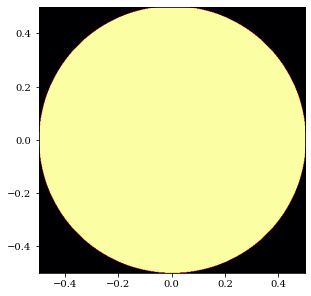

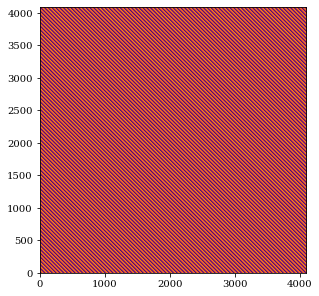

0.014180705429488683


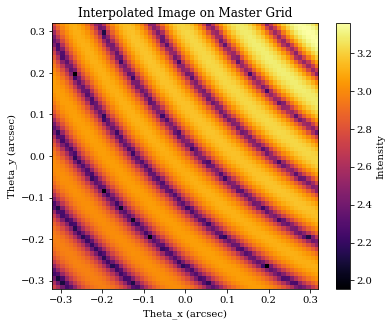

In [51]:
#FINAL FORM (THANKS CHATGPT!). THe physics should be right... I hope the interpolation is too
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import numpy.fft as fft

# Constants
D = 1            # Mirror diameter (m)
res = 512        # Aperture resolution (pixels)

# keep my oversize nice and high
oversize = 8
L = D * oversize
N = res * oversize

# Spatial grid for the aperture
x = np.linspace(-L/2, L/2, N)
y = np.linspace(-L/2, L/2, N)
X, Y = np.meshgrid(x, y)

# aperture function!!
aperture = ((X**2 + Y**2) < (D/2)**2) & ((X**2 + Y**2) > (0/2)**2)
spiders = [(0, 0.1), (np.pi/2, 0.1)]

# Add spider vanes
# for angle, width in spiders:
#     # Rotate coordinates to align the vane along the x-axis in the rotated frame
#     x_rot = X * np.cos(angle) + Y * np.sin(angle)
#     aperture &= np.abs(x_rot) > width / 2

plt.imshow(aperture,extent=[-L/2, L/2, -L/2, L/2])
plt.xlim(-D/2,D/2)
plt.ylim(-D/2,D/2)
plt.show()
# Define point sources (theta_x_arcsec, theta_y_arcsec, wavelength)
point_sources = [
    (1, 1, 550e-9)
    
    ]  # Can add more sources

# Define master angular grid (arcseconds)
x_center, y_center = 0, 0

#arcsecond resolution of final grid (i.e. pixels per arcsecond)
# the thing is... this isn't averaging over bins, just interpolating to the centre
# not really that good
# I think from here I'm just gonna use dlux
dxy = 0.01
#arcsecond image radius
rad = 32*dxy
# x and y radius in pixels
x_radius, y_radius = int(rad/dxy), int(rad/dxy)

x_image = np.linspace(x_center - x_radius*dxy, x_center + x_radius*dxy, int(2*x_radius))
y_image = np.linspace(y_center - y_radius*dxy, y_center + y_radius*dxy, int(2*y_radius))
X_image, Y_image = np.meshgrid(x_image, y_image)

# Initialize final intensity map
final_intensity = np.zeros_like(X_image)

for theta_x_arcsec, theta_y_arcsec, wavelength in point_sources:
    # Convert arcsec to radians
    theta_x = np.radians(theta_x_arcsec / 3600)
    theta_y = np.radians(theta_y_arcsec / 3600)

    # Phase shift
    phase_shift = np.exp((+1j * 2 * np.pi / wavelength) * 
                         (X * np.sin(theta_x) + Y * np.sin(theta_y)))
    
    plt.imshow(np.angle(phase_shift))
    plt.show()
    aperture_source = aperture * phase_shift

    # Fourier transform (image in angular space)
    image_source = fft.fftshift(fft.fft2(aperture_source))

    # Define the theta grid
    image_theta_x_arcsec = (wavelength * fft.fftshift(fft.fftfreq(N, L/N)) / np.pi) * (180 * 3600)
    image_theta_y_arcsec = (wavelength * fft.fftshift(fft.fftfreq(N, L/N)) / np.pi) * (180 * 3600)

    #just displays the arcseconds per pixel of original funcs
    print(image_theta_x_arcsec[1]-image_theta_x_arcsec[0])

    # Create structured grid
    Theta_X, Theta_Y = np.meshgrid(image_theta_x_arcsec, image_theta_y_arcsec, indexing='ij')
    
    # Compute intensity
    intensity = np.abs(image_source)**2

    # all of the above I mostly understand / did myself, asked chatgpt for this part
    
    # Interpolate onto master grid
    interp_func = RegularGridInterpolator((image_theta_x_arcsec, image_theta_y_arcsec), intensity)
    points_to_interpolate = np.column_stack((X_image.ravel(), Y_image.ravel()))
    intensity_on_master = interp_func(points_to_interpolate).reshape(X_image.shape)
    
    # Sum intensities for multiple sources (incoherent sum)
    final_intensity += intensity_on_master

# Plot final intensity map
plt.imshow(np.log10(final_intensity**0.5), extent=(x_image[0], x_image[-1], y_image[0], y_image[-1]), origin='lower', cmap='inferno')
plt.colorbar(label="Intensity")
plt.title("Interpolated Image on Master Grid")
plt.xlabel("Theta_x (arcsec)")
plt.ylabel("Theta_y (arcsec)")
plt.show()


In [41]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

# Define our wavefront properties
wf_npix = 512  # Number of pixels in the wavefront
diameter = 1.0  # Diameter of the wavefront, meters

# Construct a simple circular aperture
coords = dlu.pixel_coords(wf_npix, diameter)
aperture = dlu.circle(coords, 0.5 * diameter)

# Define our detector properties
psf_npix = 64  # Number of pixels in the PSF
psf_pixel_scale = 0.01

# Define the optical layers
# Note here we can pass in a tuple of (key, layer) paris to be able to 
# access the layer from the optics object with the key!
layers = [
    (
        "aperture",
        dl.layers.TransmissiveLayer(transmission=aperture, normalise=True),
    )
]
oversam = 1
# Construct the optics object
optics = dl.AngularOpticalSystem(
    wf_npix, diameter, layers, psf_npix, psf_pixel_scale, oversam
)
positions = dlu.arcsec2rad(np.array([[0,0]]))
wavels = np.array([550e-9])
fluxes = np.array([1])

# Construct the source object and examine it
points = dl.PointSources(wavels, positions, fluxes)
# Models some wavelengths through the system

psf = points.model(optics)

# Get out aperture transmission for plotting
# Note we can use the 'aperture' key we supplied in the layers to access 
# that layer directly from the optics object!
transmission = optics.aperture.transmission

# Let examine the optics object! The dLux framework has in-built 
# pretty-printing, so we can just print the object to see what it contains.
print(optics)

AngularOpticalSystem(
  wf_npixels=512,
  diameter=1.0,
  layers={
    'aperture':
    TransmissiveLayer(transmission=f32[512,512], normalise=True)
  },
  psf_npixels=64,
  oversample=1,
  psf_pixel_scale=0.01
)


/var/folders/2s/299fsjvd5w13x4x_w7x554fh0000gn/T/ipykernel_65630/1073302074.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(abs(np.abs(psf/np.max(psf))-np.abs(final_intensity/np.max(final_intensity)))))


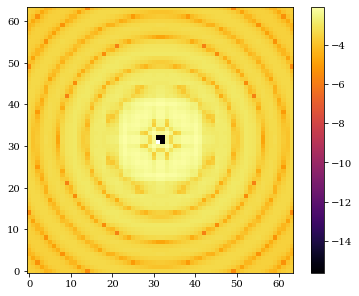

In [47]:
plt.imshow(np.log10(abs(np.abs(psf/np.max(psf))-np.abs(final_intensity/np.max(final_intensity)))))
plt.colorbar()
plt.show()